## Democratic Primary Poll Analysis

*This notebook includes data that was previously scraped & cleaned and then edited in Excel to: (1) remove duplicate poll records & (2) include columns w/ polling method classifications

In [1]:
import pandas as pd
import numpy as np
import re
import altair as alt
import altair_latimes as lat

In [2]:
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [3]:
file = pd.read_csv('scraped_polls_duplicates_removed.csv')

In [4]:
len(file)

387

In [5]:
file.head(1)

,Dates,Region,Pollster,Sample,Voter_Type,Pollster_Grade,Biden,Sanders,Harris,Warren,...,Castro,Gabbard,Klobuchar,Steyer,Poll_End_Date,Cell,Landline,Text,Online,Mail
0,"Sep 17-20, 2019",National,HarrisX,761,LV,C+,32,15,5,20,...,1,1,1,1,9/20/2019,NaN,NaN,NaN,1,NaN


In [6]:
# Replacing 'Unclear' w/ 0.5 & NaN w/ 0 to enable arithmetic operations on column values
file = file.replace({'Unclear':0.5}).replace({np.nan:0}).reset_index(drop=True)

In [7]:
file.Pollster[file.Pollster.str.contains('\*')].unique()

array(['Benenson Strategy Group*', 'Public Policy Polling*',
       'WPA Intelligence*'], dtype=object)

In [8]:
# Removing asterisks from a few names that have them
file.Pollster = file.Pollster.apply(lambda x:x.replace('*',''))

In [9]:
file.Pollster[file.Pollster.str.contains('\*')].unique()

array([], dtype=object)

In [10]:
file.dtypes

Dates              object
Region             object
Pollster           object
Sample             object
Voter_Type         object
Pollster_Grade     object
Biden               int64
Sanders             int64
Harris              int64
Warren              int64
Buttigieg           int64
Booker              int64
Yang                int64
de Blasio           int64
Williamson          int64
O'Rourke            int64
Delaney             int64
Castro              int64
Gabbard             int64
Klobuchar           int64
Steyer              int64
Poll_End_Date      object
Cell               object
Landline           object
Text              float64
Online             object
Mail              float64
dtype: object

In [11]:
file[['Cell', 'Landline', 'Online']] = file[['Cell', 'Landline', 'Online']].astype(float)

In [12]:
file.head(1)

,Dates,Region,Pollster,Sample,Voter_Type,Pollster_Grade,Biden,Sanders,Harris,Warren,...,Castro,Gabbard,Klobuchar,Steyer,Poll_End_Date,Cell,Landline,Text,Online,Mail
0,"Sep 17-20, 2019",National,HarrisX,761,LV,C+,32,15,5,20,...,1,1,1,1,9/20/2019,0.0,0.0,0.0,1.0,0.0


In [13]:
file.to_csv('all_polls_data.csv', index=False)

In [14]:
# Removing Candidate Poll Results
cols = list(file.columns[:5]) + list(file.columns[-6:])

In [15]:
file = file[cols]

In [16]:
file.head(1)

,Dates,Region,Pollster,Sample,Voter_Type,Poll_End_Date,Cell,Landline,Text,Online,Mail
0,"Sep 17-20, 2019",National,HarrisX,761,LV,9/20/2019,0.0,0.0,0.0,1.0,0.0


---

### (1) Pollster Poll Counts

In [17]:
total_count = []
for pollster in file.Pollster.unique():
    df = file[file.Pollster == pollster]
    total_count.append(len(df.Dates.unique()))  # Removing duplicates (i.e. nat'l & state poll conducted on same date)

In [18]:
pollster_poll_counts_df = pd.DataFrame({'Pollster':file.Pollster.unique(), 'Total Polls Count': total_count})
pollster_poll_counts_df = pollster_poll_counts_df.sort_values(['Total Polls Count', 'Pollster'], ascending=[False, True]).reset_index(drop=True)
pollster_poll_counts_df.head()

,Pollster,Total Polls Count
0,Morning Consult,53
1,HarrisX,40
2,Change Research,37
3,Emerson College,25
4,YouGov,25


In [19]:
# For DataWrapper chart
pollster_poll_counts_df.head(15).to_csv('top15_pollster_counts.csv', index='False')

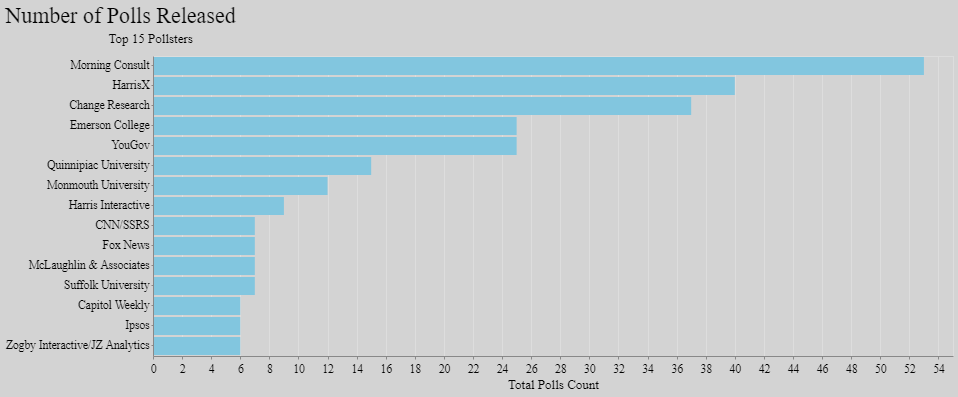

In [20]:
alt.Chart(pollster_poll_counts_df[:15], title='Number of Polls Released').mark_bar().encode(
x=alt.X('Total Polls Count'),
y=alt.Y('Pollster', title='Top 15 Pollsters', sort=list(pollster_poll_counts_df['Total Polls Count'].values))).properties(background='lightgray')

---

### (2) Poll Methods

In [21]:
# Each pollster is assigned to the poll method they used (no pollsters used multiple methods, thankfully)
polls_dict = {
    'Landline': ['St. Pete Polls'],
    'Cell/Landline': ['ABC News/Washington Post', 'Bendixen & Amandi International','Benenson Strategy Group', 'Bold Blue Campaigns', 'CNN/SSRS', 'David Binder Research',  'Denno Research',
                        'Fox News', 'GBAO', 'GQR Research', 'IBD/TIPP', 'Marquette Law School', 'Monmouth University', 'Muhlenberg College', 'NBC News/Wall Street Journal', 
                        'Public Policy Institute of California', 'Quinnipiac University', 'Ragnar Research Partners', 'Remington Research Group', 'RKM Research and Communications Inc.', 
                        'Saint Anselm College', 'Selzer & Co.', 'Siena College', 'SoonerPoll.com', 'Suffolk University', 'Tel Opinion Research', 'University of New Hampshire', 'Victory Research',
                        'TargetPoint/GQR Research'],
    'Landline/Online': ['Emerson College', 'Florida Atlantic University'],
    'Landline/Text': ['Chism Strategies'],
    'Cell/Land/Text': ['Firehouse Strategies/Øptimus'],
    'Cell/Land/Online': ['Gravis Marketing'],
    'Cell/Online': ['Public Policy Polling', 'Texas Lyceum'],
    'Online': ['Avalanche Strategy', 'Capitol Weekly', 'Change Research', 'Civiqs', 'Claster Consulting', 'Climate Nexus', 'Crantford Research',  
                'D-CYFOR', 'Echelon Insights', 'Harris Interactive', 'HarrisX', 'Ipsos', 'McLaughlin & Associates', 
                'Morning Consult', 'Pew Research Center', 'SurveyMonkey', 'SurveyUSA',  'UC Berkeley', 'University of Texas at Tyler', 'YouGov', 'YouGov Blue/Data for Progress', 
                'Zogby Interactive/JZ Analytics'],
    'Mail': ['USC Dornsife/LA Times', 'WPA Intelligence', 'Franklin & Marshall College', 'Hampton University', 'Univision/University of Houston/Latino Decisions/North Star Opinion Research', 'We Ask America']
    }

---

#### Confirming that no polls are missing:

In [22]:
len(file.Pollster.unique())

65

In [23]:
pollsters_list = []
for key in polls_dict:
    for val in polls_dict[key]:
        pollsters_list.append(val)
print(len(set(pollsters_list)))

65


In [24]:
for pollster in file.Pollster.unique():
    if pollster not in set(pollsters_list):
        print(pollster)

---

#### Linking pollster to poll method

In [25]:
pollster_list = []
method_list = []

for key in polls_dict:
    for pollster in polls_dict[key]:
        pollster_list.append(pollster)
    method_list.extend(np.full(len(polls_dict[key]), key))

In [26]:
poll_methods_df = pd.DataFrame({'Pollster':pollster_list, 'Method':method_list})

In [27]:
poll_methods_df.head()

,Pollster,Method
0,St. Pete Polls,Landline
1,ABC News/Washington Post,Cell/Landline
2,Bendixen & Amandi International,Cell/Landline
3,Benenson Strategy Group,Cell/Landline
4,Bold Blue Campaigns,Cell/Landline


---

#### Pollsters w/ Partially Missing Data:

In [28]:
for pollster in file.Pollster.unique():
    df = file[file.Pollster == pollster]
    row_values = [list(x)[-5:] for x in df.values]  # List of lists containing row values
    values = []
    for lst in row_values:
        values += lst
    if .5 in set(values) and len(set(values)) > 2:
        print(pollster, set(values))

Suffolk University {0.5, 0.0, 877.0, 178.0, 822.0, 123.0}
Tel Opinion Research {288.0, 0.0, 0.5, 200.0, 400.0, 464.0, 336.0, 312.0}


*Need to exclude .5 from the avgs below

---

#### Avg. % of Data Collected Via a Polling Method (each pollster):

In [29]:
# Calculating avg. percentage of poll data collected via each method (for each pollster)
cell_vals = []
landline_vals = []
text_vals = []
online_vals = []
mail_vals = []

dframe = file.copy()
partially_missing = ['Suffolk University', 'Tel Opinion Research'] # Polling methods recorded for some polls, but not all- need to exclude from being factored into avgs (below)
partials = dframe.Pollster.isin(partially_missing)  
unclear = dframe['Cell'] == .5  # Ratio of cell to landline calls is missing
partials_removed_df = dframe[~(partials & unclear)]

for pollster in poll_methods_df.Pollster.unique():
    df = partials_removed_df[partials_removed_df.Pollster == pollster]

    cell = df['Cell'].mean()
    landline = df['Landline'].mean()
    text = df['Text'].mean()
    online = df['Online'].mean()
    mail = df['Mail'].mean()
    
    lists = [cell_vals, landline_vals, text_vals, online_vals, mail_vals]
    methods = [cell, landline, text, online, mail]
    total = sum(methods)
    counter = 0    
    
    for lst in lists:
        lst.append(int(round(methods[counter]/total * 100, 0)))
        counter += 1

In [30]:
poll_methods_df['Cell'] = cell_vals
poll_methods_df['Landline'] = landline_vals
poll_methods_df['Text'] = text_vals
poll_methods_df['Online'] = online_vals
poll_methods_df['Mail'] = mail_vals

In [31]:
# Including names of pollsters who weren't explicitly listed in FiveThirtyEight's collection but jointly conducted polls w/ the following pollsters
poll_methods_df.Pollster = poll_methods_df.Pollster.replace({'Selzer & Co.':'CNN/Des Moines Register (Selzer & Co.)', 
                                                             'Suffolk University':'Suffolk University/USA Today', 
                                                             'Ipsos':'Reuters/Ipsos'})

In [32]:
poll_methods_df = poll_methods_df.sort_values(['Pollster']).reset_index(drop=True)
poll_methods_df.head()

,Pollster,Method,Cell,Landline,Text,Online,Mail
0,ABC News/Washington Post,Cell/Landline,65,35,0,0,0
1,Avalanche Strategy,Online,0,0,0,100,0
2,Bendixen & Amandi International,Cell/Landline,50,50,0,0,0
3,Benenson Strategy Group,Cell/Landline,50,50,0,0,0
4,Bold Blue Campaigns,Cell/Landline,50,50,0,0,0


In [33]:
# For plotting data in DataWrapper
poll_methods_df.to_csv('pollster_methods.csv', index=False)

---

#### Plotting Data via Altair

In [34]:
alt_chart = pd.DataFrame()
for col in ['Landline', 'Cell', 'Text', 'Online', 'Mail']:
    df = poll_methods_df.copy()
    df['Percent'] = poll_methods_df[col]
    df['Type'] = np.full(len(df), col)
    alt_chart = pd.concat([alt_chart, df])

In [35]:
alt_chart.head()

,Pollster,Method,Cell,Landline,Text,Online,Mail,Percent,Type
0,ABC News/Washington Post,Cell/Landline,65,35,0,0,0,35,Landline
1,Avalanche Strategy,Online,0,0,0,100,0,0,Landline
2,Bendixen & Amandi International,Cell/Landline,50,50,0,0,0,50,Landline
3,Benenson Strategy Group,Cell/Landline,50,50,0,0,0,50,Landline
4,Bold Blue Campaigns,Cell/Landline,50,50,0,0,0,50,Landline


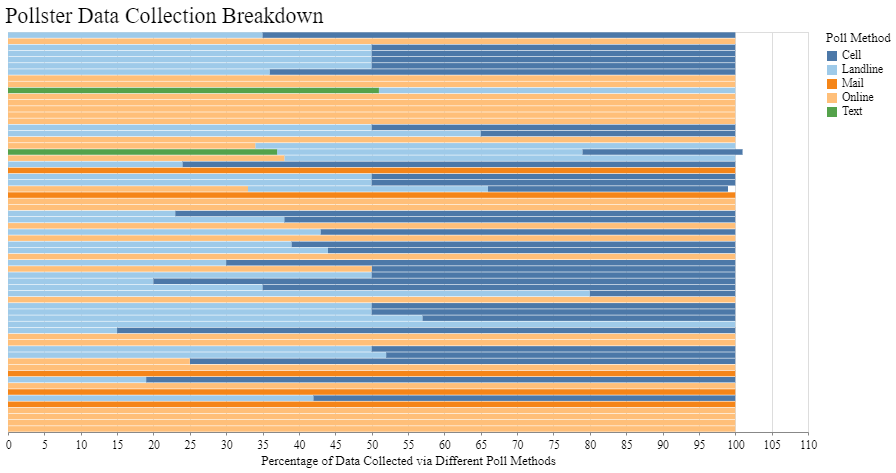

In [36]:
# Y-axis containing pollster names were removed to focus attention on the relative frequency of each method (indicated by bar color)
poll_methods = alt.Chart(alt_chart, title='Pollster Data Collection Breakdown').mark_bar().encode(
x=alt.X('sum(Percent)', title='Percentage of Data Collected via Different Poll Methods'),
y=alt.Y('Pollster', axis=None),
color=alt.Color('Type', title='Poll Method', scale=alt.Scale(scheme='tableau20')),
tooltip=['Pollster', 'Cell', 'Landline', 'Text', 'Online', 'Mail']).properties(background='white', height=400)
poll_methods

*Bars totalling more/less than 100% will be normalized in DataWrapper

---

## Polling Method Counts

In [37]:
poll_types = []
poll_counts = []
for key in polls_dict:
    poll_types.append(key)
    poll_counts.append(len(polls_dict[key]))

In [38]:
polls_df = pd.DataFrame({'Poll Type':poll_types, 'Poll Count':poll_counts}).sort_values('Poll Count', ascending=False)

In [39]:
polls_df['Poll Type'] = polls_df['Poll Type'].apply(lambda x:x.replace('/', ' & '))

In [40]:
polls_df

,Poll Type,Poll Count
1,Cell & Landline,29
7,Online,22
8,Mail,6
2,Landline & Online,2
6,Cell & Online,2
0,Landline,1
3,Landline & Text,1
4,Cell & Land & Text,1
5,Cell & Land & Online,1


In [41]:
types = list(polls_df['Poll Type'].values)

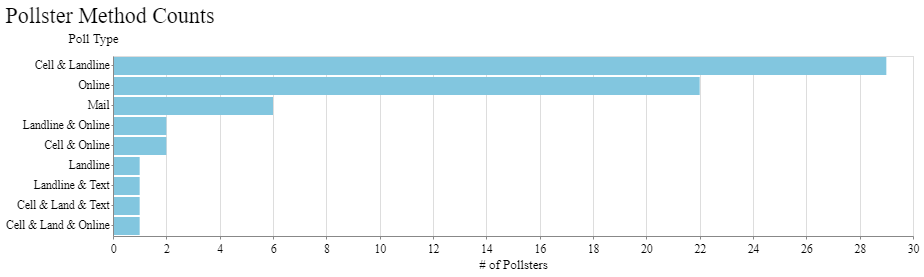

In [42]:
alt.Chart(polls_df, title='Pollster Method Counts').mark_bar().encode(
    y=alt.Y('Poll Type', sort=types),
    x=alt.X('Poll Count', title='# of Pollsters')).properties(background='white')

---

### Findings:
- Online is the most utilized method for national polls
- Cell/Landline is the most utilized method for state polls

---